In [ ]:
# object detection data augmentation
https://albumentations.ai/docs/#getting-started-with-albumentations
https://albumentations.ai/docs/examples/
https://github.com/albumentations-team/albumentations
https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
https://albumentations.ai/docs/examples/showcase/
    
Installed albumentation in fastai env

## to resolve
1. what format should the transformed bounding box coordinates be saved in? - currently it is a list, in pascal_voc format from xml file

2. saving the augmented images - the GC10 dataset is greyscale; but for colored images we need to ensure that reading in the images using cv2 & then saving them doesn't alter the color channels

In [1]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A
import xml.etree.ElementTree as ET
import pandas as pd

In [10]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids): #, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        #class_name = category_id_to_name[category_id]
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [3]:
def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)


    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))

        ax[0].imshow(image)
        ax[0].set_title('Original image')

        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))

        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)            
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)

        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')

        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')

        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()

    if filename is not None:
        f.savefig(filename)

    return augmented['image'], augmented['mask'], augmented['bboxes']



def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]

## Bbox coordinates can be in different formats : 
pascal_voc : [x_min, y_min, x_max, y_max]
albumentations: normalized[x_min, y_min, x_max, y_max]
coco : [x_min, y_min, width, height]
yolo : normalized[x_center, y_center, width, height]

not all transforms work with bbox  https://albumentations.ai/docs/getting_started/transforms_and_targets/

Also, Bounding boxes can be stored on the disk in different serialization formats: JSON, XML, YAML, CSV

Albumentations expects that bounding boxes will be represented as a list of lists. 
A bounding box definition should have at list four elements that represent the coordinates of that bounding box. 
Besides four coordinates, each definition of a bounding box may contain one or more extra values. 
You can use those extra values to store additional information about the bounding box, such as a class label of the object inside the box. https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

'''
bboxes = [
    [23, 74, 295, 388, 'dog'],
    [377, 294, 252, 161, 'cat'],
    [333, 421, 49, 49, 'sports ball'],
]
'''
Use RandomSizedBBoxSafeCrop to keep all bounding boxes from the original image

## define transform

In [ ]:
'''
# when bbox doesn't contain class_label
bbox_params = A.BboxParams(format='coco', min_area=1, min_visibility=0.5, label_fields=['class_labels'])

tsfm = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomSizedCrop((800 - 100, 800 + 100), 600, 600),
    A.RGBShift(p=1),
    A.Blur(blur_limit=11, p=1),
    A.RandomBrightness(p=1),
    A.CLAHE(p=1),
], bbox_params=bbox_params, p=1)

#transform = A.Compose(
#    [A.CenterCrop(height=280, width=280, p=1)],
#    bbox_params=A.BboxParams(format='coco', min_visibility=0.3, label_fields=['class_labels']),

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']

In [11]:
# when bbox contains class_label 
# For GC10 data, xml file is in pascal_voc format

#bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']) #, min_area=1, min_visibility=0.5, label_fields=['category_id'])

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.RandomSizedCrop((800 - 100, 800 + 100), 600, 600),
    A.ShiftScaleRotate(p=0.5),
    A.RGBShift(p=0.5),
    #A.Blur(blur_limit=11, p=1),
    A.RandomBrightness(p=0.5),
    A.CLAHE(p=0.5),],
    #bbox_params=bbox_params, p=1
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']),
)


In [12]:
# get image & bbox info

def get_img_bbox(path,fname):
    # image
    image = cv2.imread(path + fname + '.jpg')
    
    # bbox
    xml_list = []
    class_label = []
    xml_file = path + fname + '.xml'
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for member in root.findall('object'):
        name = root.find('filename').text
        if '.jpg' in name:
            name = name
        else:
            name = name+'.jpg'
        #value = (name,  #root.find('filename').text,
        #         int(root.find('size')[0].text),
        #         int(root.find('size')[1].text),
        #         member[0].text,
        #         int(member[4][0].text),
        #         int(member[4][1].text),
        #         int(member[4][2].text),
        #         int(member[4][3].text)
        #         )
        value = [int(member[4][0].text),
                 int(member[4][1].text),
                 int(member[4][2].text),
                 int(member[4][3].text)#,
                 #member[0].text
                ]
        class_label.append(member[0].text)
        xml_list.append(value)

    return image, xml_list, class_label

path = "C:/Users/DAR9KOR/Desktop/data/sample_datasets/defect_detection/2_codes/GC10_detection/workspace2/training_demo/images/val/"
fname = "img_01_424826800_00003"
image, bboxes, class_labels = get_img_bbox(path, fname)

In [13]:
bboxes

[[1256, 795, 1470, 1000]]

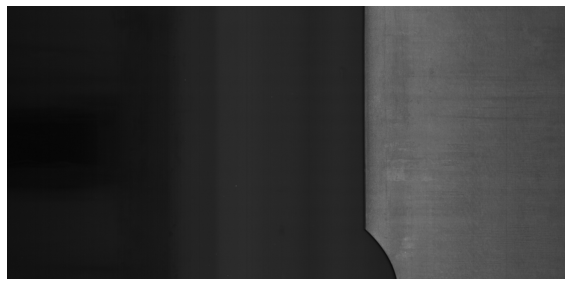

In [8]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image)

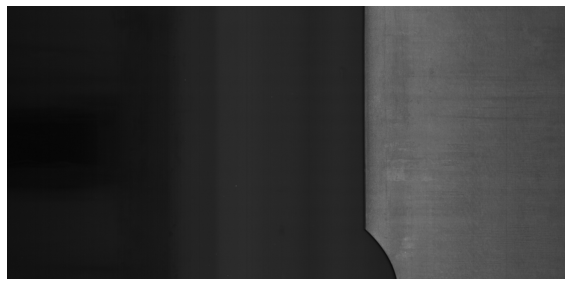

In [22]:
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image)

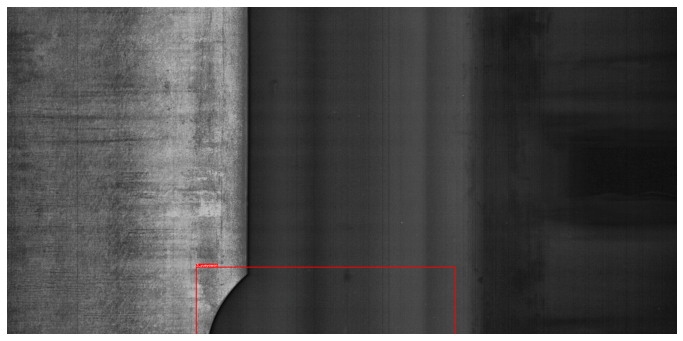

In [15]:
transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['class_labels'],
#    category_id_to_name,
)

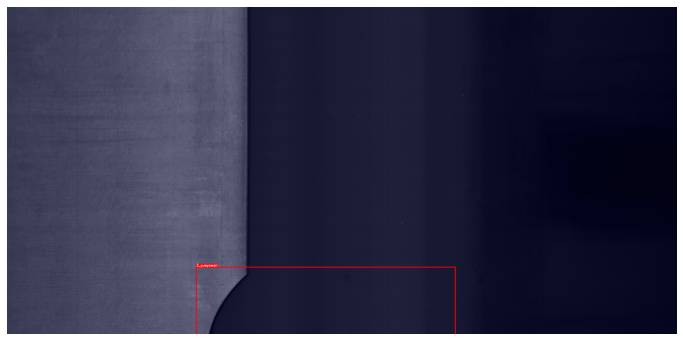

In [20]:
transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['class_labels'],
#    category_id_to_name,
)

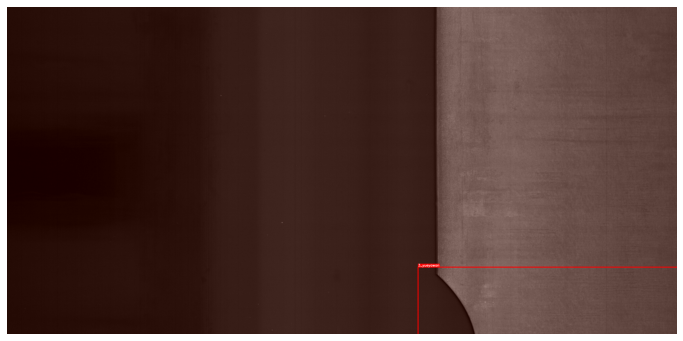

In [21]:
transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['class_labels'],
#    category_id_to_name,
)

In [18]:
r = augment_and_show(transform, image, class_labels, bboxes)#, #instance_labels,
                     #titles, thickness=2,
                     #font_scale_orig=2, 
                     #font_scale_aug=1)

TypeError: mask must be numpy array type